In [1]:
## IMPORTS
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.7 MB/s eta 0:00:00


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

dataset = Planetoid(root='./data', name='Cora')  # Itt 'Cora' helyett használhatsz másik Planetoid adathalmazt is.
data = dataset[0]

In [65]:
## PARAMETERS
embedding_dim = 128
walk_length=80
context_size=10
walks_per_node=10
num_negative_samples=1
p=0.5
q=0.5

lr=0.05
epochs=50
batch_size=64

In [66]:
!pip install wandb
import wandb
wandb.login()

True

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the Node2Vec model
model = Node2Vec(data.edge_index, embedding_dim, walk_length=walk_length, context_size=context_size,
                 walks_per_node=walks_per_node, num_negative_samples=num_negative_samples, p=p, q=q, sparse=True).to(device)

# Initialize the SGD optimizer with momentum
loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=lr)

print(model)

Node2Vec(2708, 128)


In [68]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask], z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.title(f'embs_p {p}_q {q}_size {embedding_dim}')
    plt.savefig(f'embs_p {p}_q {q}_size {embedding_dim}.jpg')
    plt.show()

In [69]:
wandb.init(project="project_lab2_node2vec")
for epoch in tqdm(range(epochs)):
    loss = train()
    acc = test()
    wandb.log({"Loss": loss, "Acc": acc, "Epoch": epoch + 1})
wandb.finish()

100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


Acc,▁▇█▇▇███▇█▇█▇▇█▇▆▇▇▆████▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.687
Epoch,50
Loss,0.8342


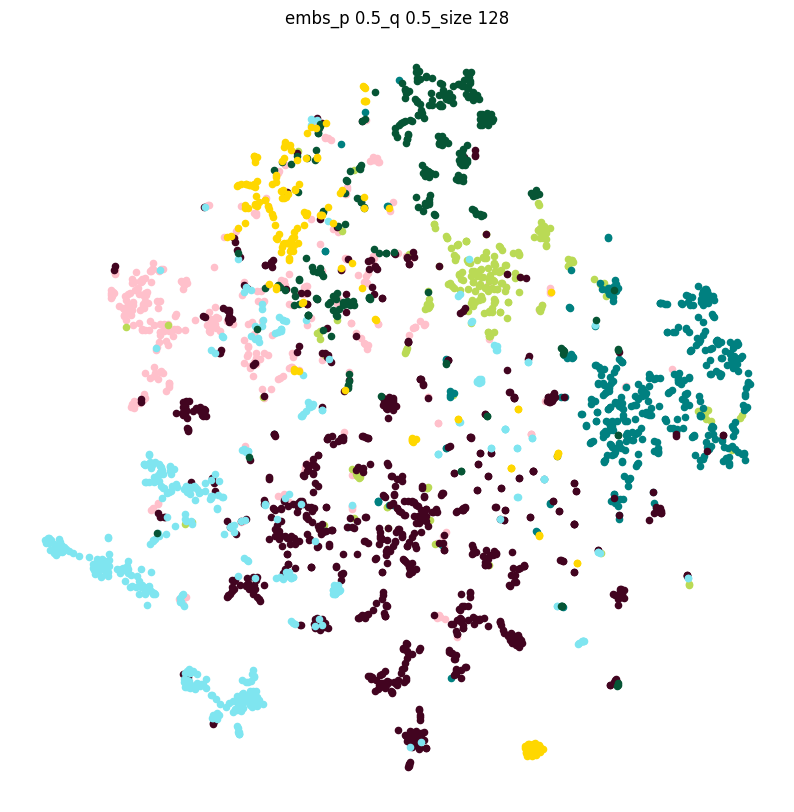

In [70]:
colors = [ '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700' ]
plot_points(colors)

In [71]:
import numpy as np
import torch
from torch_geometric.datasets import Planetoid
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Planetoid adathalmaz betöltése
dataset = Planetoid(root='./data', name='Cora')  # Használja a megfelelő adathalmaz nevet
data = dataset[0]

# Node2Vec modell beágyazások betöltése
embeddings = model()
embeddings = embeddings.cpu().detach().numpy()
# Az éleket tartalmazó gráf előkészítése
edge_index = data.edge_index

# Gráf mérete
num_nodes = data.num_nodes

# Beágyazások közötti hasonlóság kiszámítása (példában koszinusz hasonlóság)
similarity_matrix = np.dot(embeddings, embeddings.T)

matrix_size = num_nodes
matrix = np.zeros((matrix_size, matrix_size))
for i,j in edge_index.T:
  matrix[i,j] = 1

predictions = similarity_matrix.flatten()
#predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
originals  = matrix.flatten()


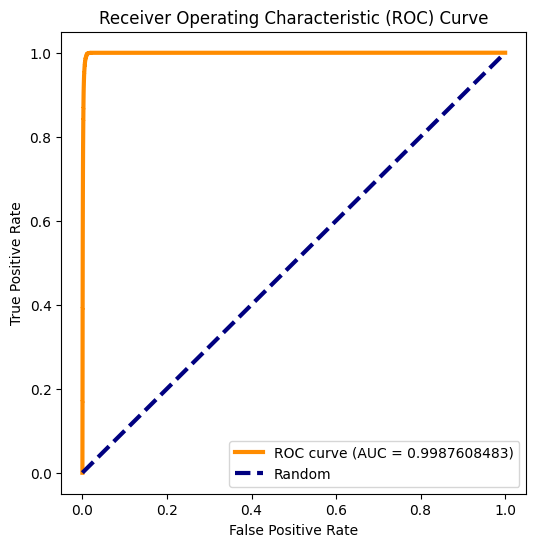

In [72]:
# ROC görbe számítása
fpr, tpr, treshold = roc_curve(originals, predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

# ROC görbe ábrázolása
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.10f})')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [73]:
## Classifier using Linear Regression on Planetoid dataset

In [74]:
# DATAFRAME
X = embeddings
y = dataset.y
columns_X = [f'feature_{i}' for i in range(X.shape[1])]
df_X = pd.DataFrame(X, columns=columns_X)

# Add the 'y' column to the DataFrame
df_X['class'] = y

# Display the DataFrame
df_X.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,class
0,0.338880,-0.115763,0.329574,-0.636910,-0.023342,0.072393,-0.129012,0.040957,0.081882,0.198268,...,-0.017792,0.070734,-0.260956,0.051952,-0.006586,-0.081482,0.211729,0.487262,0.168437,3
1,-0.040721,0.160595,-0.217644,0.259256,-0.074800,0.197321,0.059057,0.069503,0.084234,0.331883,...,0.146385,-0.037261,0.044379,-0.075013,0.225142,0.074698,-0.196041,-0.214054,-0.192495,4
2,0.200678,0.010571,-0.205017,0.113752,-0.245922,0.069491,0.072275,0.115064,0.422087,0.358646,...,0.180942,-0.199776,-0.150724,-0.156095,0.208114,0.186398,-0.250379,-0.231431,-0.191351,4
3,-0.225708,-0.047212,0.132866,0.112646,-0.148681,-0.045993,0.294228,-0.092293,-0.044799,-0.159606,...,0.157197,0.097133,-0.155112,0.053500,-0.363293,-0.297411,0.055864,0.043176,0.182240,0
4,-0.063095,-0.323436,0.155642,-0.049764,-0.094504,0.723003,0.065258,0.127195,-0.204675,-0.018270,...,-0.147311,0.217151,-0.170351,0.124205,-0.162223,0.094758,-0.092240,0.364000,0.103860,3


In [75]:
df_X['class'].value_counts()

3    818
4    426
2    418
0    351
5    298
1    217
6    180
Name: class, dtype: int64

In [76]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

X = df_X.drop('class', axis=1)
y = df_X['class']

df_columns = X.columns
scaler = StandardScaler()
df = scaler.fit_transform(X)
X = pd.DataFrame(df)
X.columns = df_columns

# Create a linear regression model
model = LinearRegression()

# Specify the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')  # You can use other scoring metrics

# Display the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean R^2:", np.mean(cross_val_scores))

Cross-Validation Scores: [0.45896191 0.51211318 0.44057682 0.38181395 0.46601285]
Mean R^2: 0.45189574024343815


In [77]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute F1 score (micro and macro)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nF1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)
print("Accuracy:", accuracy)


Confusion Matrix:
[[ 60   1   0   4   1   4   5]
 [  2  35   3   3   1   1   1]
 [  0   1  75   3   0   1   0]
 [  9   3   2 157  14   2   4]
 [  8   1   0   9  55   1   2]
 [  4   0   1   5   2  31   1]
 [  1   1   0   1   1   5  21]]

F1 Score (Micro): 0.8007380073800738
F1 Score (Macro): 0.7728405926195585
Accuracy: 0.8007380073800738


<Axes: >

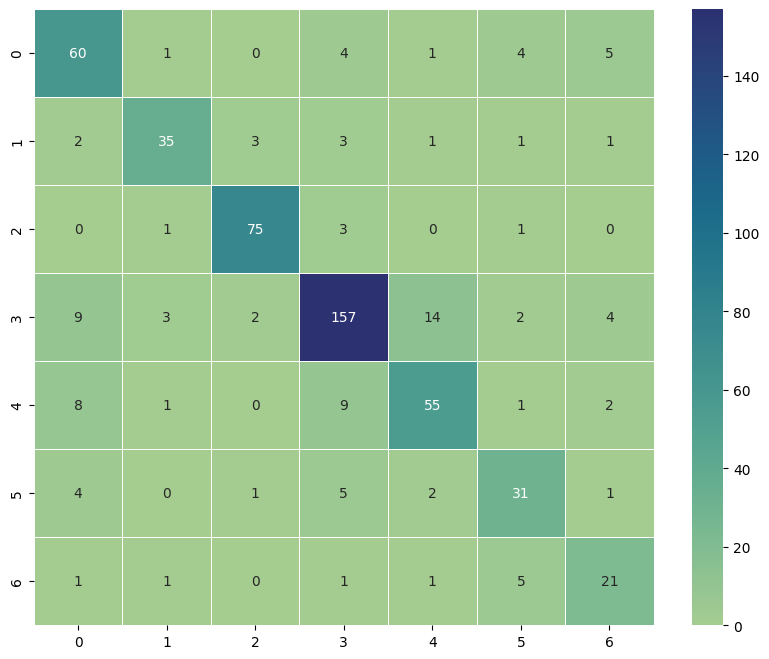

In [78]:
import seaborn as sn
df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(len(conf_matrix[0]))],
                  columns = [i for i in range(len(conf_matrix[0]))])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt=".0f",linewidth=.5, cmap="crest")